In [1]:
import os, sys
import numpy as np
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from thop import profile
from ptflops import get_model_complexity_info
torch.__version__

'1.10.1+cu113'

In [2]:
RANDOM_STATE = 111
BATCH_SIZE = 256
EPOCHS = 30
LR = 1e-4

In [3]:
dir_path = '../data/'

train, train_label = [], []
with open(dir_path + 'train.txt', 'r') as f:
  for line in f:
    data = line.split(" ")
    train.append(dir_path + data[0])
    train_label.append(data[1].replace('\n', ''))


val, val_label = [], []
with open(dir_path + 'val.txt', 'r') as f:
  for line in f:
    data = line.split(" ")
    val.append(dir_path + data[0])
    val_label.append(data[1].replace('\n', ''))


test, test_label = [], []
with open(dir_path + 'test.txt', 'r') as f:
  for line in f:
    data = line.split(" ")
    test.append(dir_path + data[0])
    test_label.append(data[1].replace('\n', ''))

print(f'訓練資料共{len(train)}筆')
print(f'驗證資料共{len(val)}筆')
print(f'測試資料共{len(test)}筆')

訓練資料共63325筆
驗證資料共450筆
測試資料共450筆


### 資料前處理

In [4]:
def data_preprocess(paths):
    features = []
    for path in tqdm(paths):
        # 讀取image，並轉為灰階影像
        img = cv2.imread(path, 0)
        img = cv2.resize(img, (32, 32))
        img = img.reshape(32, 32, 1).astype('float32')
        img = np.transpose(img, (2, 0, 1)).astype('float32')
        # 標準化(MaxAbs)，灰階影像最大為255
        img = img / 255
        features.append(img)
        
    return features

In [5]:
# 轉成np.array再轉成oneHotEncoding
def OneHotEncoding(labels):
    y = np.eye(50)[np.array(list(map(int, labels)))]
    return y

In [6]:
class imageDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y

In [7]:
%%time
train_data = imageDataset(data_preprocess(train), OneHotEncoding(train_label))
val_data = imageDataset(data_preprocess(val), OneHotEncoding(val_label))
test_data = imageDataset(data_preprocess(test), OneHotEncoding(test_label))

  0%|          | 0/63325 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

CPU times: user 33.2 s, sys: 1.37 s, total: 34.5 s
Wall time: 34.4 s


### LeNet-5 by pytorch
- https://github.com/ChawDoe/LeNet5-MNIST-PyTorch
- ChatGPT

In [8]:
# Define the LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self, num_labels):
        super(LeNet5, self).__init__()
        self.c1 = nn.Conv2d(1, 6, kernel_size=5)
        self.r1 = nn.ReLU()
        self.p1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.c2 = nn.Conv2d(6, 16, kernel_size=5)
        self.r2 = nn.ReLU()
        self.p2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.r3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.r4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_labels)
        self.s1 = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.c1(x)
        x = self.r1(x)
        x = self.p1(x)
        x = self.c2(x)
        x = self.r2(x)
        x = self.p2(x)
        x = x.view(x.size(0), 16*5*5)
        x = self.fc1(x)
        x = self.r3(x)
        x = self.fc2(x)
        x = self.r4(x)
        x = self.fc3(x)
        x = self.s1(x)
        return x

### Train

In [9]:
# set the DataLoader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
vaild_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=450)

# choose GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Define the LeNet-5 model, loss function and optimizer
model = LeNet5(50).to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [10]:
# record
train_acc_history = []
train_loss_history = []
valid_acc_history = []
valid_loss_history = []

# Training
for epoch in range(EPOCHS):
    train_loss = 0.0
    correct = 0
    total = 0
    times = 0
    
    for i, data in enumerate(train_loader):
        inputs, label = data
        inputs = inputs.to(device)
        label = label.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, label)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        _, corrected = torch.max(label.data, 1)
        total += label.size(0)
        correct += (predicted == corrected).sum().item()
        times = i + 1 

    train_loss_history.append(train_loss/times)
    train_acc_history.append(correct/total)
    print(f"--------------------Epoch {epoch+1}--------------------")
    print(f"Train_accuracy: {(correct/total):.4f} | Train_loss: {(train_loss/times):.4f}")
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    times = 0
    with torch.no_grad():
        for i, data in enumerate(vaild_loader):
            inputs, label = data
            inputs = inputs.to(device)
            label = label.to(device)

            # inference
            outputs = model(inputs)
            loss = criterion(outputs, label)
            val_loss += loss.item()

            # check correct
            _, predicted = torch.max(outputs.data, 1)
            _, corrected = torch.max(label.data, 1)
            val_total += label.size(0)
            val_correct += (predicted == corrected).sum().item()
            times = i + 1
            
    valid_loss_history.append(val_loss/times)
    valid_acc_history.append(val_correct/val_total)

    print(f"Val_accuracy: {(val_correct/val_total):.4f} | Val_loss: {val_loss/times:.4f}")

--------------------Epoch 1--------------------
Train_accuracy: 0.0332 | Train_loss: 3.9090
Val_accuracy: 0.0356 | Val_loss: 3.8976
--------------------Epoch 2--------------------
Train_accuracy: 0.0451 | Train_loss: 3.8940
Val_accuracy: 0.0400 | Val_loss: 3.8918
--------------------Epoch 3--------------------
Train_accuracy: 0.0498 | Train_loss: 3.8897
Val_accuracy: 0.0467 | Val_loss: 3.8842
--------------------Epoch 4--------------------
Train_accuracy: 0.0541 | Train_loss: 3.8869
Val_accuracy: 0.0533 | Val_loss: 3.8838
--------------------Epoch 5--------------------
Train_accuracy: 0.0582 | Train_loss: 3.8833
Val_accuracy: 0.0600 | Val_loss: 3.8759
--------------------Epoch 6--------------------
Train_accuracy: 0.0626 | Train_loss: 3.8805
Val_accuracy: 0.0711 | Val_loss: 3.8750
--------------------Epoch 7--------------------
Train_accuracy: 0.0631 | Train_loss: 3.8788
Val_accuracy: 0.0733 | Val_loss: 3.8711
--------------------Epoch 8--------------------
Train_accuracy: 0.0648 | Tra

### Test

In [11]:
# Test the model on the test dataset
correct = 0
total = 0
# starter = torch.cuda.Event(enable_timing=True)
# ender = torch.cuda.Event(enable_timing=True)
start_time = time.time()
with torch.no_grad():
    for data in test_loader:
        inputs, label = data
        inputs = inputs.to(device)
        label = label.to(device)

        # inference 
        # starter.record()
        outputs = model(inputs)
        # ender.record()
        
        # check correct
        _, predicted = torch.max(outputs.data, 1)
        _, corrected = torch.max(label.data, 1)
        total += label.size(0)
        correct += (predicted == corrected).sum().item()
        
        # record time
        # torch.cuda.synchronize()
        # curr_time = starter.elapsed_time(ender)
        
print(f'Accuracy on the test images: {(correct/total):.4f}')
# print(f'Inference time: {curr_time:.4f} milliseconds')
inference_time = time.time() - start_time
print(f'Inference time: {inference_time:.8f}s')

Accuracy on the test images: 0.0733
Inference time: 0.01018763s


### Curves of the training accuracy and validation accuracy

In [12]:
class plot():
    def __init__(self, train_acc_history, valid_acc_history, train_loss_history, valid_loss_history):
        self.train_acc_history = train_acc_history
        self.valid_acc_history = valid_acc_history
        self.train_loss_history = train_loss_history
        self.valid_loss_history = valid_loss_history
        
    def call(self):
        self.plot_acc()
        self.plot_loss()
        
    def plot_acc(self):
        plt.plot(self.train_acc_history)
        plt.plot(self.valid_acc_history)
        plt.title('Accuracy History')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

    def plot_loss(self):
        plt.plot(self.train_loss_history)
        plt.plot(self.valid_loss_history)
        plt.title('Loss History')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

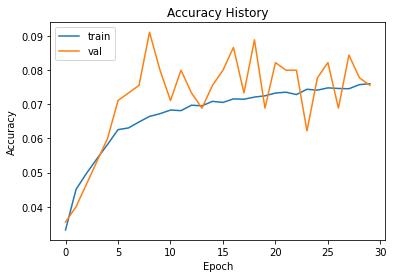

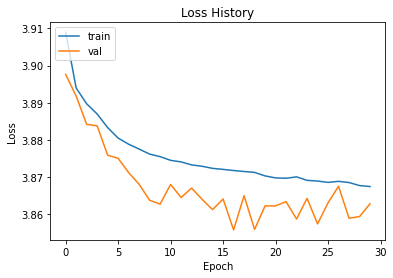

In [13]:
myPlot = plot(train_acc_history, valid_acc_history, train_loss_history, valid_loss_history)
myPlot.call()

### Flops and Space Complexity
- FLOPs（浮點運算次數）：模型計算過程中所執行的浮點運算（加法和乘法）的總次數。FLOPs通常用來估計模型的計算需求和效能，尤其是在硬體加速器的應用中。
- https://zhuanlan.zhihu.com/p/364543528

In [14]:
macs, params = get_model_complexity_info(model, (1, 32, 32), as_strings=True, print_per_layer_stat=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

LeNet5(
  65.11 k, 100.000% Params, 439.25 KMac, 100.000% MACs, 
  (c1): Conv2d(156, 0.240% Params, 122.3 KMac, 27.844% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1))
  (r1): ReLU(0, 0.000% Params, 4.7 KMac, 1.071% MACs, )
  (p1): MaxPool2d(0, 0.000% Params, 4.7 KMac, 1.071% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Conv2d(2.42 k, 3.711% Params, 241.6 KMac, 55.003% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
  (r2): ReLU(0, 0.000% Params, 1.6 KMac, 0.364% MACs, )
  (p2): MaxPool2d(0, 0.000% Params, 1.6 KMac, 0.364% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(48.12 k, 73.910% Params, 48.12 KMac, 10.955% MACs, in_features=400, out_features=120, bias=True)
  (r3): ReLU(0, 0.000% Params, 120.0 Mac, 0.027% MACs, )
  (fc2): Linear(10.16 k, 15.611% Params, 10.16 KMac, 2.314% MACs, in_features=120, out_features=84, bias=True)
  (r4): ReLU(0, 0.000% Params, 84.0 Mac, 0.019% MACs, )
  (fc3): Linear(4.25 k, 6.528%